This notebook is for plotting choropleth maps of the features.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions__epsg4326.geojson"
)

PATH_TO_OUTPUT = Path("../reports/figures/")

SAVE_FIG = True

In [3]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

gdf_rome_connected = gdf_rome.drop(index=[97]).reset_index()

(155, 36)


In [5]:
gdf_rome[gdf_rome.index==97]

,area_code,area_name,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights,n_shops,density_shops,street_len_tot,street_density,...,pop_density,avg_CO_2_per_road,CO_2_alpha,avg_NO_x_per_road,NO_x_alpha,avg_PM_per_road,PM_alpha,avg_VOC_per_road,VOC_alpha,geometry
97,20O,Martignano,17426.285886,1.085391e+07,0.0,0.0,1,0.092133,0.0,0.0,...,0.0,400.844902,1.300818,0.209284,1.338998,0.00378,1.082074,0.961731,1.368015,"POLYGON ((12.31377 42.13708, 12.31385 42.13705..."


## Spatial subdivisions

In [6]:
reg_colors = ['#ffe6ff' if reg != 'Martignano' else '#bfbfbf' for reg in gdf_rome.area_name]

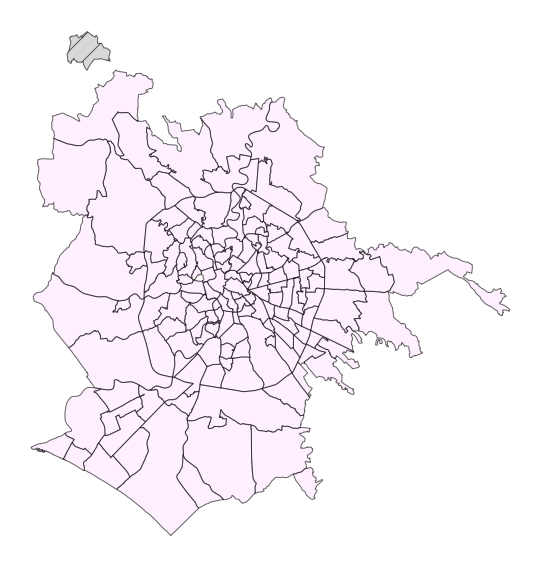

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf_rome.loc[gdf_rome.area_name != 'Martignano'].plot(
    ax=ax,
    #figsize=(12, 12),
    edgecolor="black",
    color='#ffe6ff',
    alpha=0.6
)
gdf_rome.loc[gdf_rome.area_name == 'Martignano'].plot(
    ax=ax,
    #figsize=(12, 12),
    edgecolor="black",
    color='#bfbfbf',
    alpha=0.6,
    hatch='/'
)
'''
for x, y, label in zip(gdf_rome.geometry.centroid.x, gdf_rome.geometry.centroid.y, gdf_rome.area_code):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
'''
ax.set_axis_off()
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'map_urban_areas.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'map_urban_areas.png', format='png', dpi=300)

plt.show()

## Plotting features

In [4]:
feature_to_predict = "avg_CO_2_per_road"

all_predictors = [
    'n_traffic_lights', 'density_traffic_lights', 
    'n_shops', 'density_shops', 
    'street_len_tot', 'street_density', #'motorway_ratio',
    'motorway_roads_density', 'trunk_roads_density',
    'primary_roads_density', 'all_heavy_roads_density',
    'n_food_amenities', 'density_food_amenities', 
    'n_education_amenities', 'density_education_amenities', 
    'n_service_amenities', 'density_service_amenities', 
    'n_all_amenities', 'density_all_amenities',
    'perc_roads_bc', 'car_accidents',
    'perc_people_close_to_public_transport', 'pop_density',
]

non_correlated_features = [
    'density_traffic_lights',
    'street_density',
    'motorway_roads_density',
    'trunk_roads_density',
    'primary_roads_density',
    'density_all_amenities',
    'perc_roads_bc',
    'car_accidents',
    'perc_people_close_to_public_transport',
    'pop_density'
]

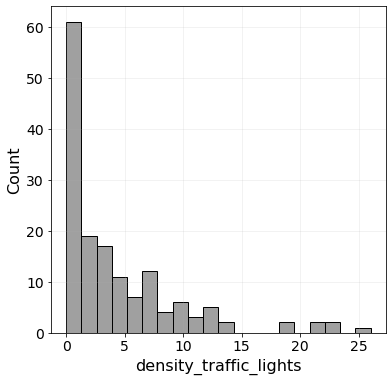

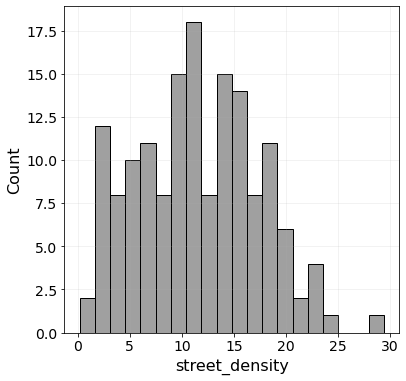

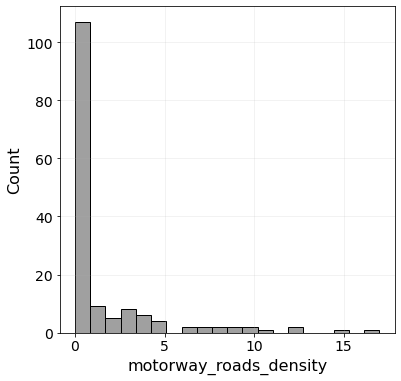

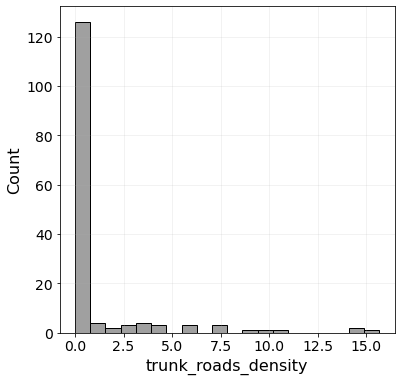

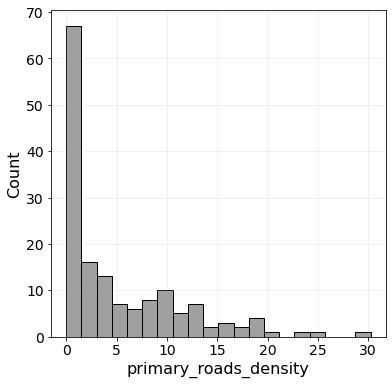

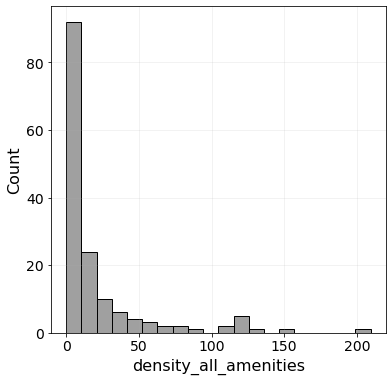

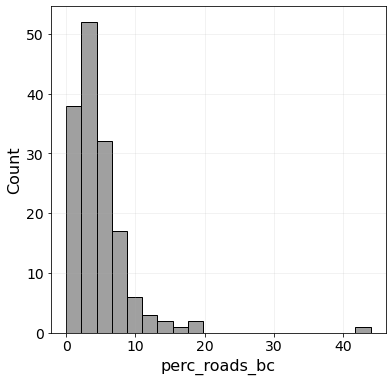

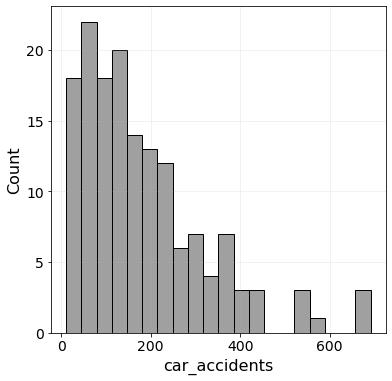

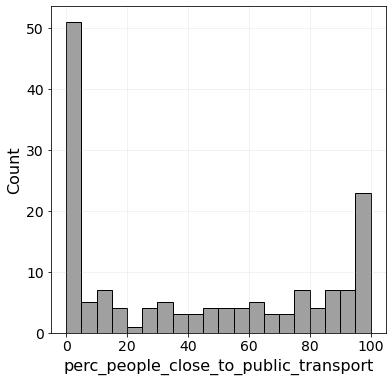

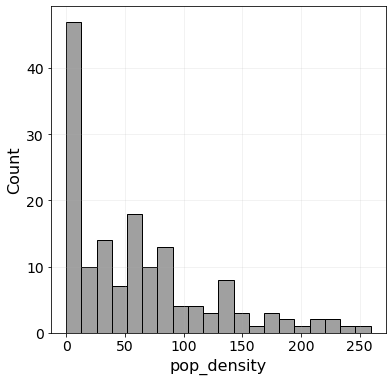

In [46]:
for c_feat in non_correlated_features: 
    fig, ax = plt.subplots(1,1, figsize=(6,6))

    #ax[0].hist(y, bins=50, color='black')
    sns.histplot(gdf_rome_connected[c_feat], color="gray", kde=False, bins=20, ax=ax)
    #ax[0].set_title('before transformation', fontsize=15)
    ax.set_xlabel(c_feat, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(alpha=0.2)

    if SAVE_FIG:
        plt.savefig(PATH_TO_OUTPUT / 'hist_y_co2_transformation.svg', format='svg')
        plt.savefig(PATH_TO_OUTPUT / 'hist_y_co2_transformation.png', format='png')

    plt.show()

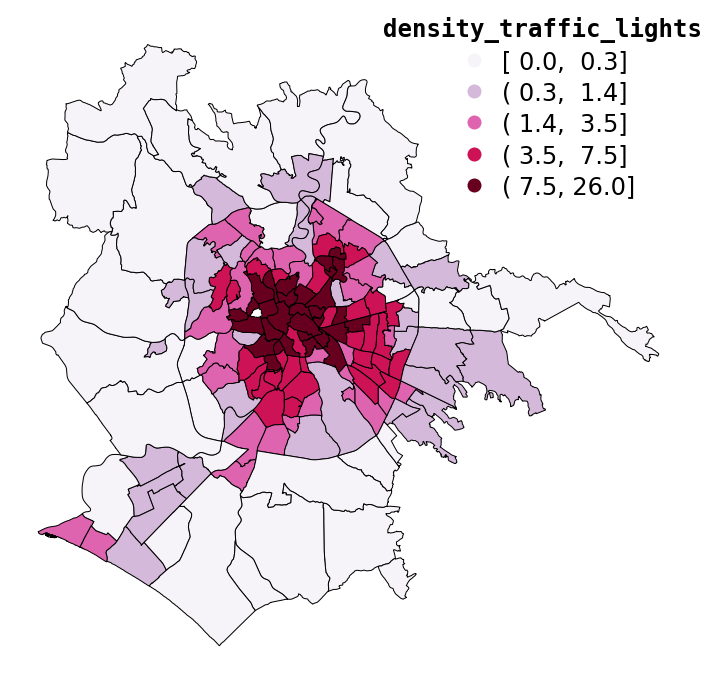

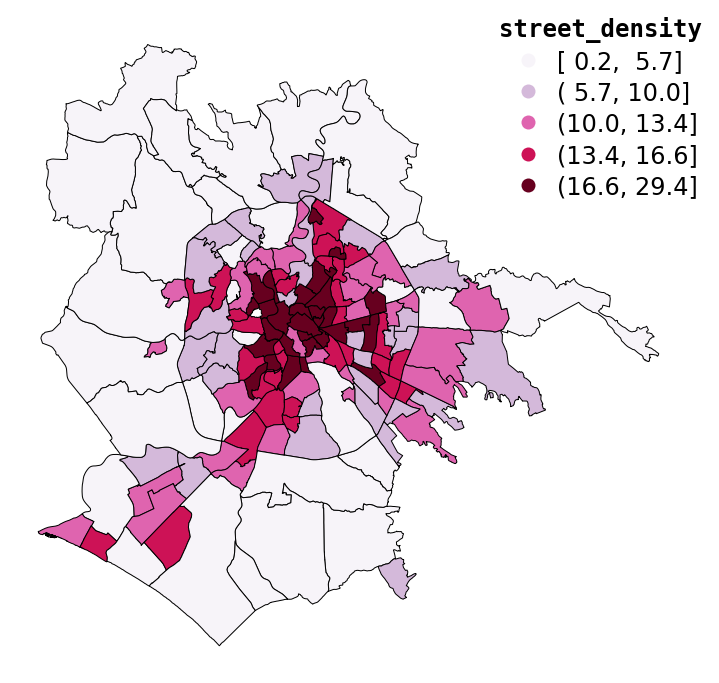

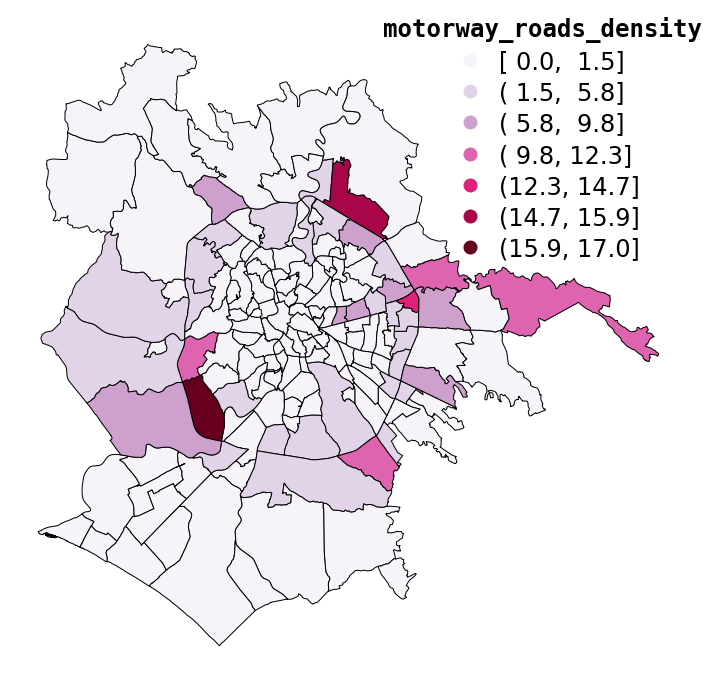

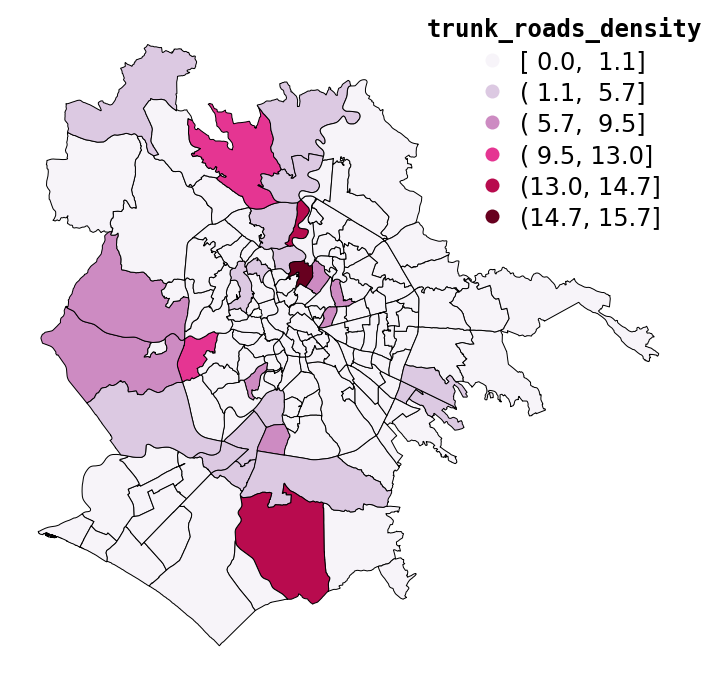

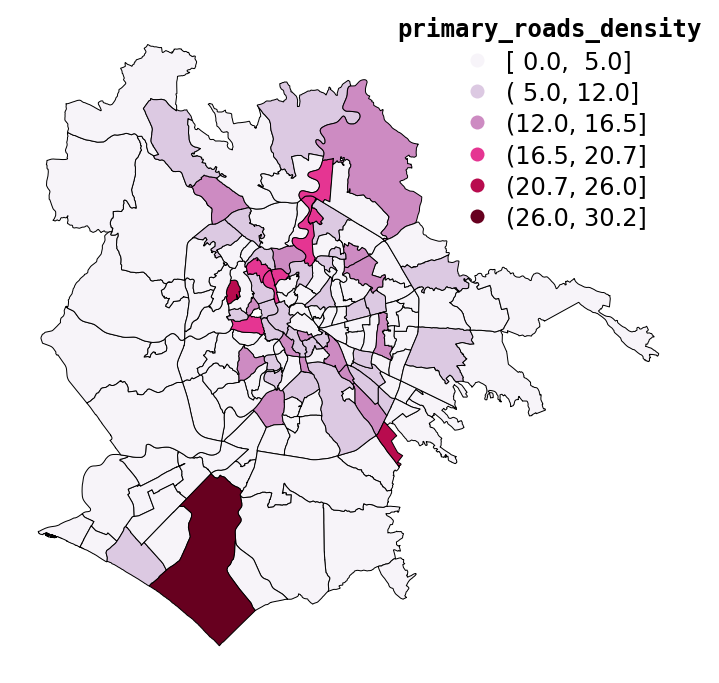

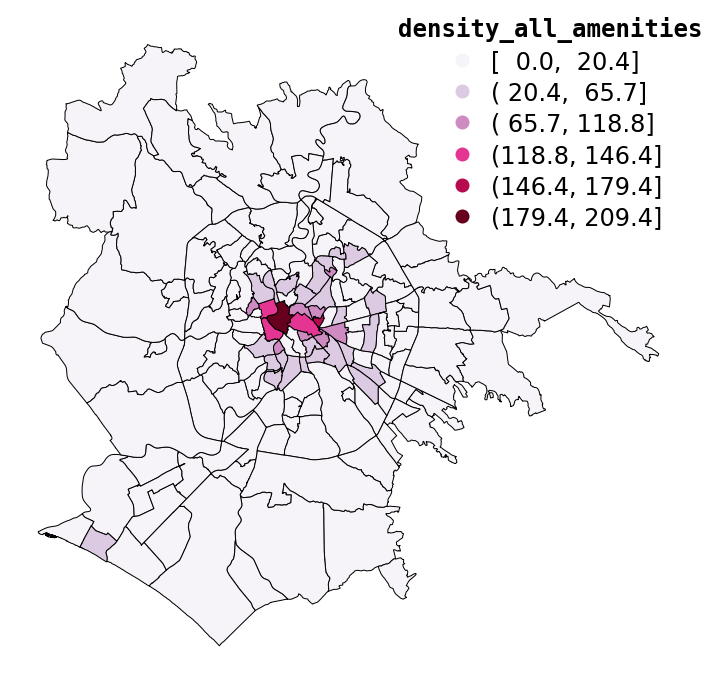

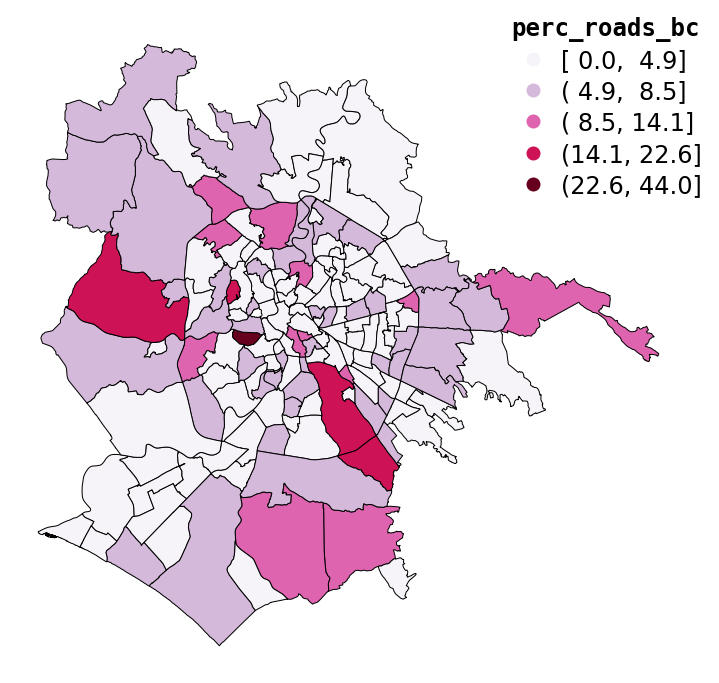

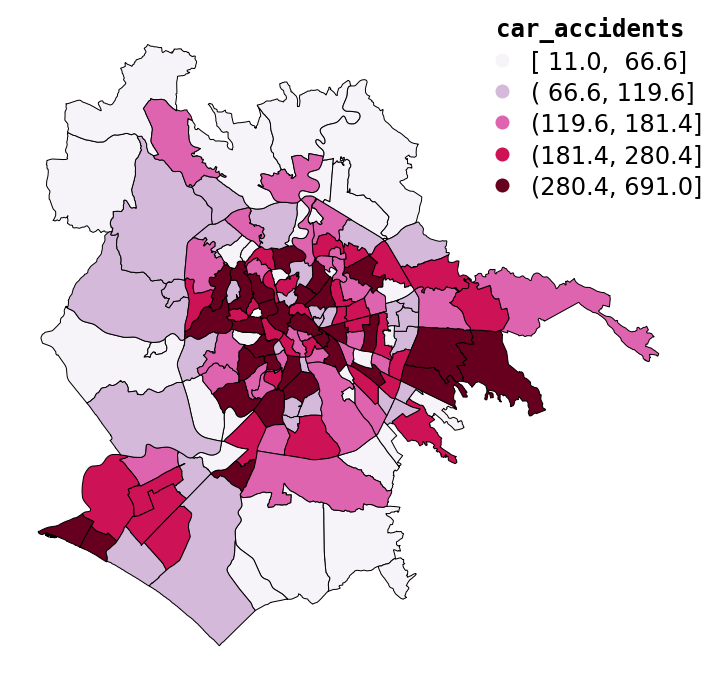

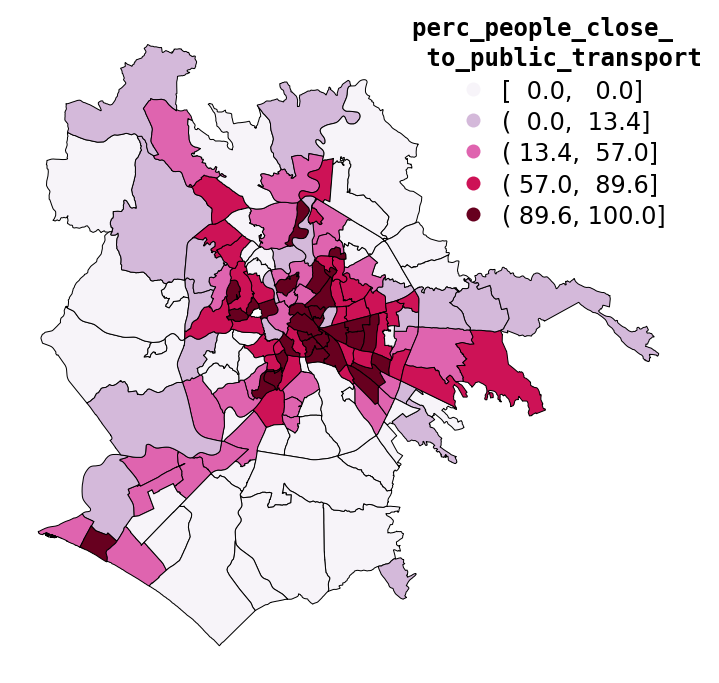

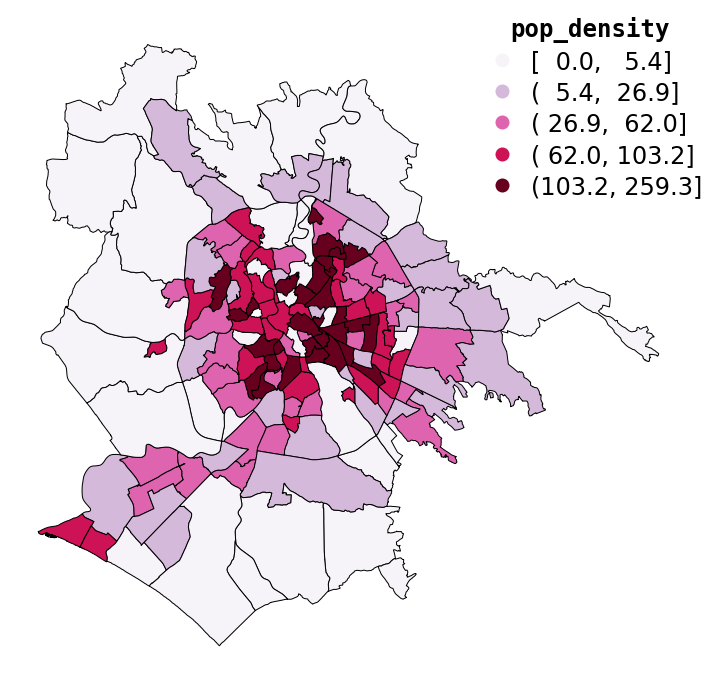

In [52]:
## https://geographicdata.science/book/notebooks/05_choropleth.html#head-tail-breaks

map__feat__scheme = {feat: 'HeadTailBreaks' if feat in ['motorway_roads_density', 'trunk_roads_density', 'primary_roads_density', 'perc_roads_bc', 'density_all_amenities'] else 'quantiles' for feat in non_correlated_features}


for c_feat in non_correlated_features:
    
    col_lim = max(abs(gdf_rome_connected[c_feat].min()), abs(gdf_rome_connected[c_feat].max()))

    fig, ax = plt.subplots(figsize=(10, 10))

    gdf_rome_connected.plot(
        ax=ax,
        column=c_feat,
        legend=True,
        #figsize=(12, 12),
        edgecolor="black",
        cmap="PuRd",
        #vmin=-col_lim,
        #vmax=col_lim,
        legend_kwds={'markerscale':1.4, 'fontsize': 24, #'title': c_feat, 'title_fontsize':22, 
                     'bbox_to_anchor':(1.05,1.03), 'frameon':False, 'handletextpad':0.2, 'interval':True, 
                     'labelspacing':0.3, 'fmt':"{:.1f}"},
        scheme=map__feat__scheme[c_feat], k=5
    )

    #ax.set_title(c_feat)
    leg = ax.get_legend()
    if c_feat == 'perc_people_close_to_public_transport':
        leg.set_title('perc_people_close_ \n to_public_transport')
    else:
        leg.set_title(c_feat)
    plt.setp(leg.get_title(),fontsize=24, family='monospace', weight='bold')
    #ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)
    ax.set_axis_off()
    plt.tight_layout()
    
    SAVE_FIG = True
    if SAVE_FIG:
        fig_name = 'map_feature__%s' %c_feat
        plt.savefig(PATH_TO_OUTPUT / str(fig_name + '.pdf'), format='pdf', bbox_inches='tight')
        plt.savefig(PATH_TO_OUTPUT / str(fig_name + '.png'), format='png', bbox_inches='tight')

    plt.show()

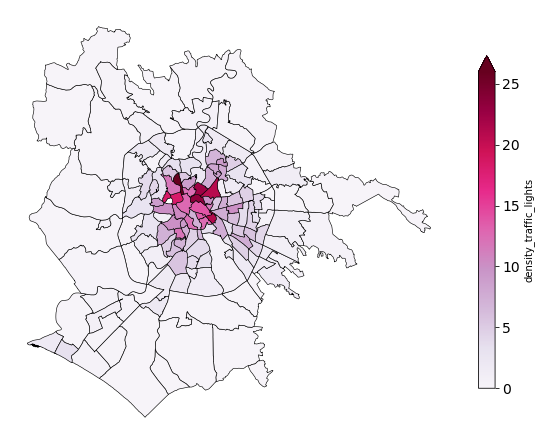

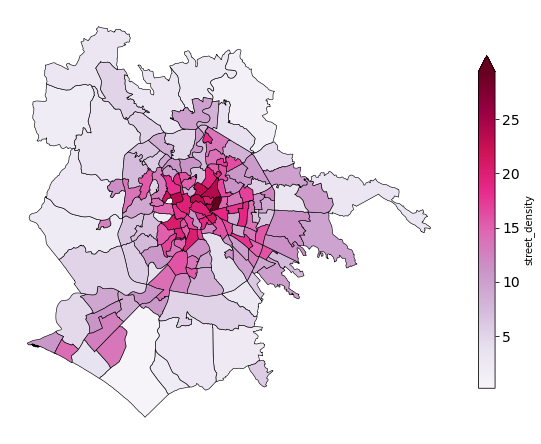

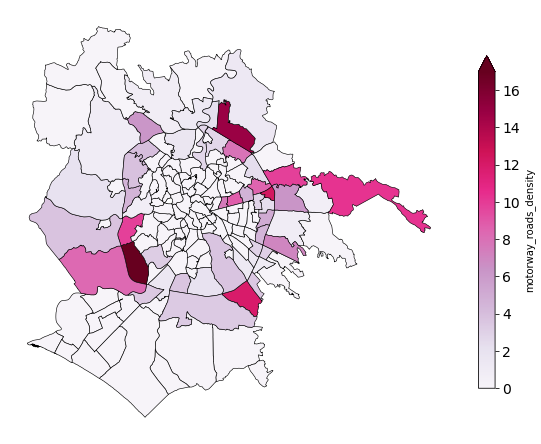

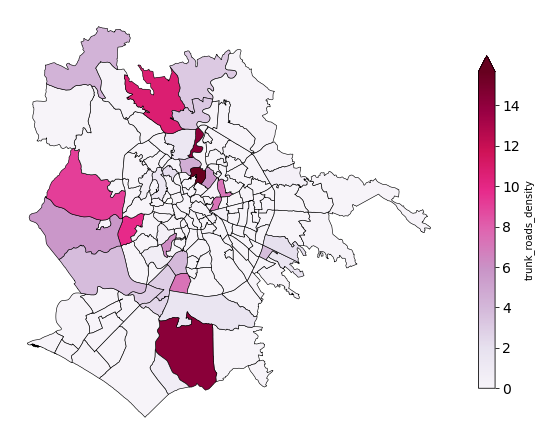

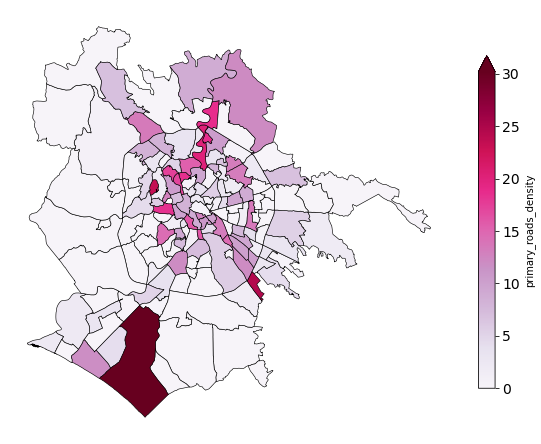

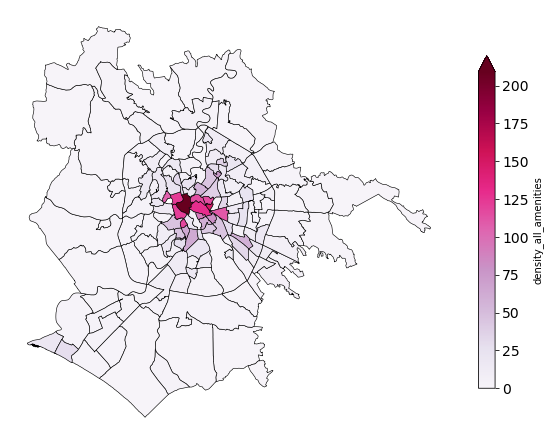

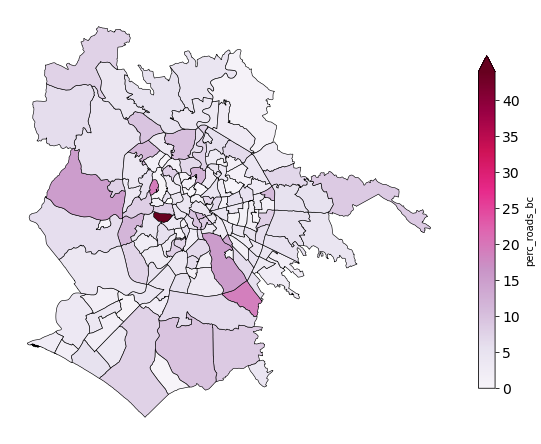

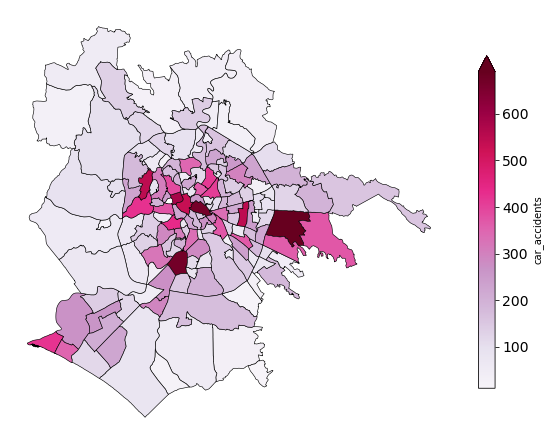

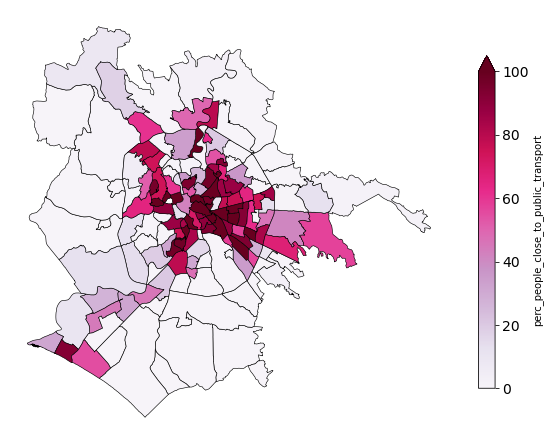

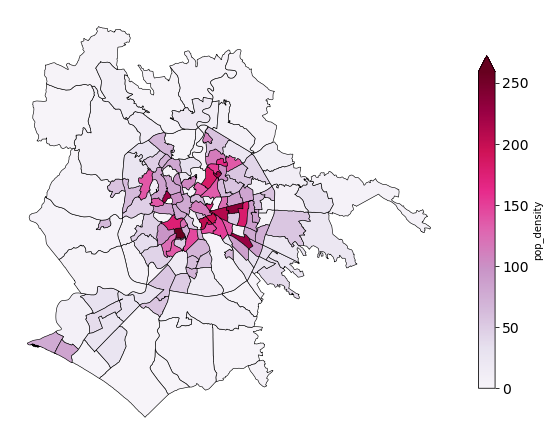

In [48]:
# alternatively, with colorbar (but no alternative mapping scheme)

for c_feat in non_correlated_features:
    fig, ax = plt.subplots(1, figsize=(8,8))
    gdf_rome_connected.plot(ax=ax, 
                            column=c_feat, 
                            cmap='PuRd', edgecolor='black', 
                            linewidth=0.6, 
                            legend=True, 
                            legend_kwds={'label': c_feat, 
                                         'orientation': "vertical", 
                                         'shrink':0.6, 'extend':'max'},
                           #scheme='quantiles'
                           )
    cbar = ax.get_figure().get_axes()[1]
    cbar.tick_params(labelsize=14)

    #ax.set_title('Traffic light density', fontsize=18, pad=10)
    ax.set_axis_off()
    plt.tight_layout()

    plt.show()